### This notebook describes laser hotspot relaxation. 

#### This is a common scenario in which to start studying electron and thermal transport. In this problem, a 500 eV electron plasma has a 100 eV hotspot over a width of about 30 $\mu m$

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import yaml

from jax import config

config.update("jax_enable_x64", True)
from adept import ergoExo

MLflow Version: 2.15.0
MLflow Tracking URI: file:///Users/archis/Dev/code/ergodic/adept-notebooks/vfp/mlruns


### Let's take a look at the temperature and heat flow

In [2]:
with open("configs/hotspot.yaml", 'r') as stream:
    cfg = yaml.safe_load(stream)

exo = ergoExo()
modules = exo.setup(cfg=cfg)
sim_out, post_processed_output, mlflow_run_id = exo(modules)

# run_id = "980b946d53d24dedbc2490dd6a6245fe"

# mlflow_uri = "/Users/archis/Dev/code/ergodic/adept/mlruns"

flds = post_processed_output["fields"] #xr.open_dataset(f"{mlflow_uri}/245005904525781388/{run_id}/artifacts/binary/fields-t=1.0.nc")
flds

tmax 5371.635975525843 dt 13.429089938814606
xmax 1791.7848939101202 dx 3.4995798709182036


2024/10/17 07:01:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/10/17 07:01:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Successfully removed /var/folders/tz/l3jmsqhd7tbfz3rjb276f_3r0000gn/T/tmp7riedybm


/Users/archis/Dev/code/ergodic/adept-notebooks/venv/lib/python3.12/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
2024/10/17 07:02:01 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/17 07:02:01 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Successfully removed /var/folders/tz/l3jmsqhd7tbfz3rjb276f_3r0000gn/T/tmp3w2jr8_9


<xarray.Dataset> Size: 545kB
Dimensions:         (t (ps): 11, x (um): 512)
Coordinates:
  * t (ps)          (t (ps)) float64 88B 0.0 0.1 0.2 0.3 0.4 ... 0.7 0.8 0.9 1.0
  * x (um)          (x (um)) float64 4kB 0.09766 0.293 0.4883 ... 99.71 99.9
Data variables:
    fields-P a.u.   (t (ps), x (um)) float64 45kB ...
    fields-T keV    (t (ps), x (um)) float64 45kB ...
    fields-T a.u.   (t (ps), x (um)) float64 45kB ...
    fields-U a.u.   (t (ps), x (um)) float64 45kB ...
    fields-b a.u.   (t (ps), x (um)) float64 45kB ...
    fields-e a.u.   (t (ps), x (um)) float64 45kB ...
    fields-n cm-3   (t (ps), x (um)) float64 45kB ...
    fields-n n_c    (t (ps), x (um)) float64 45kB ...
    fields-ni a.u.  (t (ps), x (um)) float64 45kB ...
    fields-q a.u.   (t (ps), x (um)) float64 45kB ...
    fields-v a.u.   (t (ps), x (um)) float64 45kB ...
    fields-kappa_c  (t (ps), x (um)) float64 45kB ...

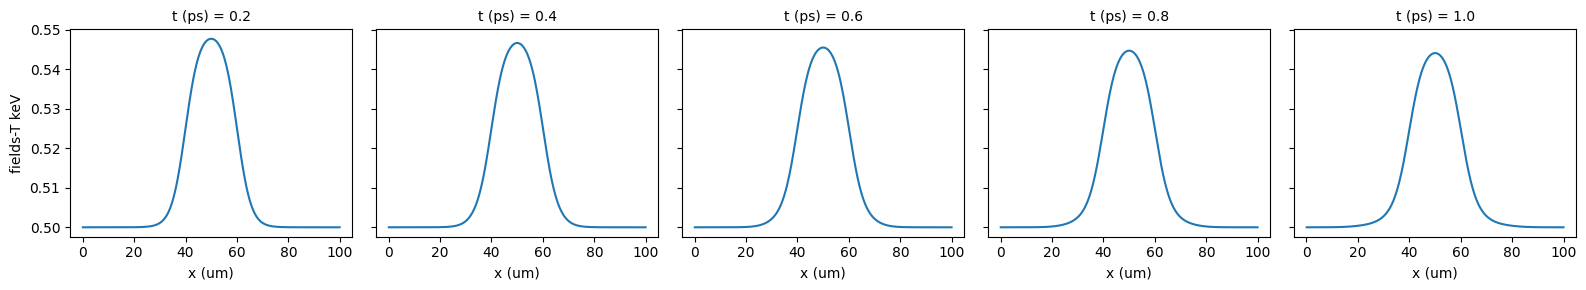

In [3]:
flds["fields-T keV"][2::2].plot(col="t (ps)")

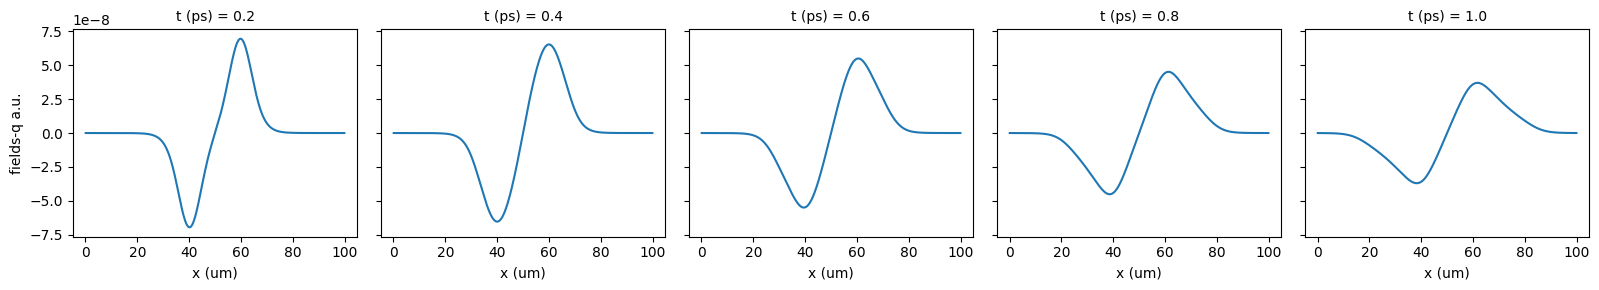

In [4]:
flds["fields-q a.u."][2::2].plot(col="t (ps)")

#### We can look at the heat flow coefficient $\kappa$. We are only interested in the coefficient at the peak of the heat flow. The picture, as you can tell, is more complicated than $\kappa \nabla T$ but that's where we limit our discussion today.

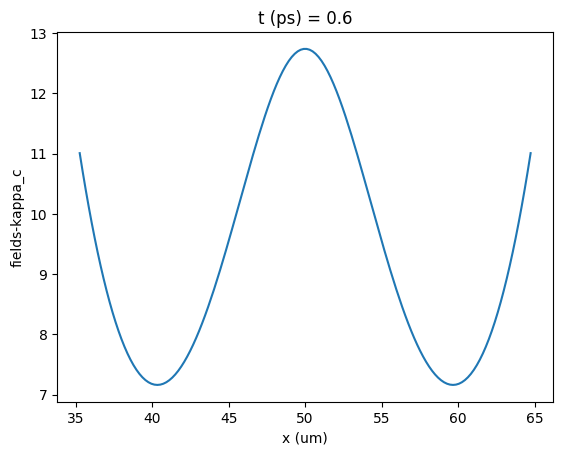

In [5]:
flds["fields-kappa_c"][6, 180:-180].plot()

#### and see that it is suppressed wrt to the "local" limit as calculated by e.g. Epperlein Haines 1986

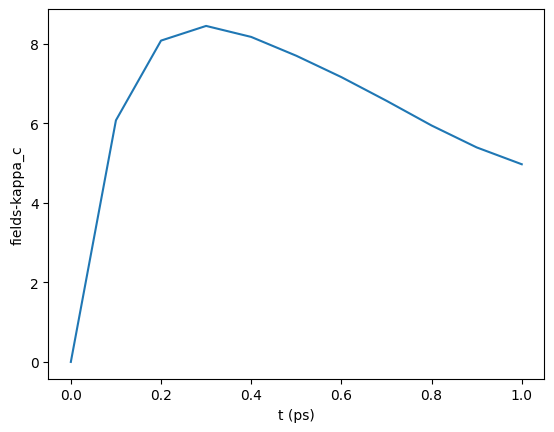

In [6]:
np.amin(flds["fields-kappa_c"][:,180:-180],axis=1).plot()

#### We can compare the calculated heat flow coefficient to that predicted by local transport theory. The local coefficient is logged in the run as a metric. We can look it up using the mlflow API

In [7]:
import mlflow
# mlflow_uri = "./vfp/"
# mlflow.set_tracking_uri(mlflow_uri)

In [8]:
run = mlflow.get_run(mlflow_run_id)

In [9]:
run.data.metrics

{'run_time': 41.7393,
 'kappa': 64.3772,
 'kappa_eh': 11.9081,
 'postprocess_time': 11.3191,
 'system/network_receive_megabytes': 1.4848000000001775,
 'system/system_memory_usage_percentage': 36.0,
 'system/disk_available_megabytes': 40348.0,
 'system/system_memory_usage_megabytes': 12365.9,
 'system/network_transmit_megabytes': 0.13824000000022352,
 'system/cpu_utilization_percentage': 33.5,
 'system/disk_usage_megabytes': 10265.7,
 'system/disk_usage_percentage': 20.3}

In [10]:
run.data.metrics["kappa_eh"]

11.9081

#### This lets us plot the calculated coefficient normalized to the local calculation

<>:2: SyntaxWarning: invalid escape sequence '\k'
<>:2: SyntaxWarning: invalid escape sequence '\k'
/var/folders/tz/l3jmsqhd7tbfz3rjb276f_3r0000gn/T/ipykernel_93161/2418799441.py:2: SyntaxWarning: invalid escape sequence '\k'
  plt.ylabel("$\kappa_{NL} / \kappa_L$", fontsize=14)


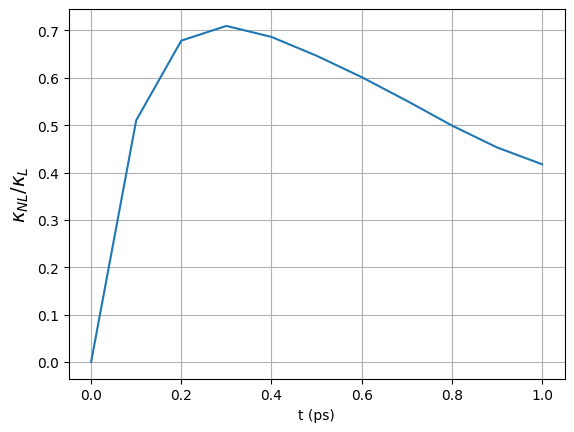

In [11]:
np.amin(flds["fields-kappa_c"][:,180:-180]/run.data.metrics["kappa_eh"],axis=1).plot()
plt.ylabel("$\kappa_{NL} / \kappa_L$", fontsize=14)
plt.grid()

#### Finally, we can also look at the distribution function. To do so, we will first reconstruct it on a Cartesian grid of (vx, vy) 

In [9]:
dist = post_processed_output["dists"]

In [10]:
dist

<xarray.Dataset> Size: 25MB
Dimensions:  (t (ps): 6, x (um): 512, v (c): 512)
Coordinates:
  * t (ps)   (t (ps)) float64 48B 0.0 0.2 0.4 0.6 0.8 1.0
  * x (um)   (x (um)) float64 4kB 0.09766 0.293 0.4883 ... 99.51 99.71 99.9
  * v (c)    (v (c)) float64 4kB 0.0002444 0.0007331 0.001222 ... 0.2495 0.25
Data variables:
    f0       (t (ps), x (um), v (c)) float64 13MB ...
    f10      (t (ps), x (um), v (c)) float64 13MB ...

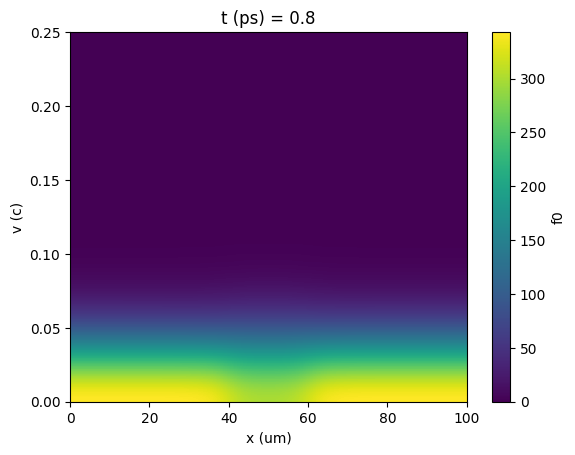

In [11]:
dist["f0"][4].T.plot()

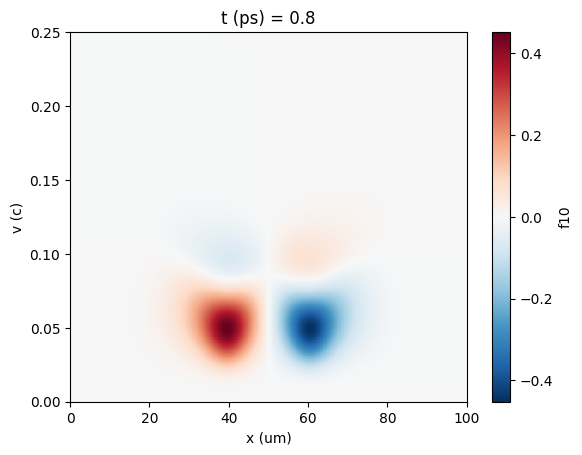

In [12]:
dist["f10"][4].T.plot()

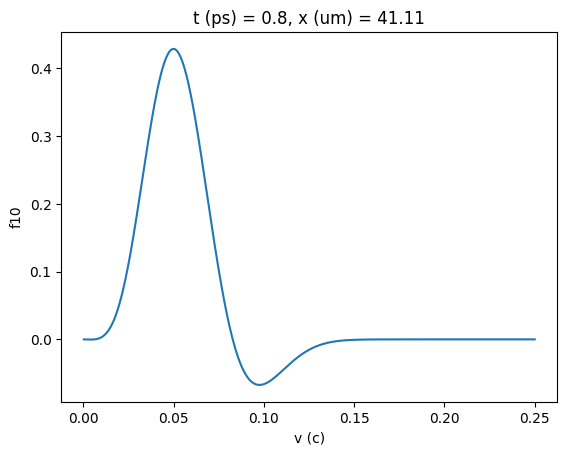

In [13]:
dist["f10"][4, 210].plot()

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/var/folders/tz/l3jmsqhd7tbfz3rjb276f_3r0000gn/T/ipykernel_65168/1982780814.py:16: SyntaxWarning: invalid escape sequence '\D'
  plt.title("$\Delta f$ @ $x = 41 \mu m$", fontsize=14)


Text(0.5, 1.0, '$\\Delta f$ @ $x = 41 \\mu m$')

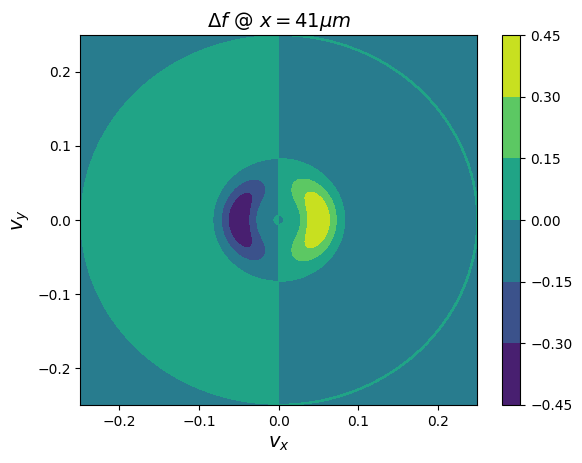

In [14]:
x = dist.coords["x (um)"].data
v = dist.coords["v (c)"].data
vt = np.hstack([-v[:-2][::-1], v[:-2]])
vx, vy = np.meshgrid(vt, vt, indexing="ij")
theta = np.arctan2(vy, vx)
vr = np.sqrt(vx**2 + vy**2)

from scipy import interpolate as interp
f0_interp = interp.interp1d(v, dist["f0"][4, 210].data, bounds_error=False, fill_value=0)
f1_interp = interp.interp1d(v, dist["f10"][4, 210].data, bounds_error=False, fill_value=0)
df = np.cos(theta)*f1_interp(vr.flatten()).reshape(vr.shape)
plt.contourf(vx, vy, df)
plt.colorbar()
plt.xlabel("$v_x$", fontsize=14)
plt.ylabel("$v_y$", fontsize=14)
plt.title("$\Delta f$ @ $x = 41 \mu m$", fontsize=14)